# K-means classification

This notebook will [classify Y79 human retinoblastoma cells](https://www.wikidata.org/wiki/Q54995129) according to cell size and resting membrane potential. The classification will assign each observation to the clusters of observations nearest to a centroid (the center of mass of the distances in a circle).

In [1]:
%pylab inline

from matplotlib.pyplot import style
import matplotlib.pyplot as plt

# use custom plots from minibrain
style.use('https://raw.githubusercontent.com/JoseGuzman/minibrain/master/minibrain/paper.mplstyle')

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Load data

In [2]:
mydata = pd.read_csv('./DataSets/Y79_data.csv', index_col='uid')
print(f'{mydata.shape[0]} observations')
mydata

95 observations


,diameter,Vmb
uid,,
Y79_000,20.89430,-27.6512
Y79_001,16.85182,-24.8687
Y79_002,17.95220,-38.0629
Y79_003,15.81813,-12.6591
Y79_004,16.68500,-36.0233
...,...,...
Y79_090,19.86000,-16.1432
Y79_091,21.75000,-29.8170
Y79_092,16.14100,-27.6429


In [3]:
from scipy.stats import lognorm

In [4]:
# Define gaussian mixture
def gauss(x,mu,sigma,A):
    """
    Solves the Gaussian function of the form:
    f(x; mu, sigma, A), where
    
    x is the observation
    mu is the location of the mean
    sigma is the standard deviation
    A is the amplitude of the Gaussian function.
    """
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

In [5]:
from scipy.optimize import curve_fit

## Bimodal distribution of cell diameters

,params,sigma
mu1,15.433695,0.330521
sigma1,2.432134,0.433704
A1,12.875506,1.845973
mu2,29.133056,3.319413
sigma2,10.315366,3.023970
A2,4.118074,0.733104


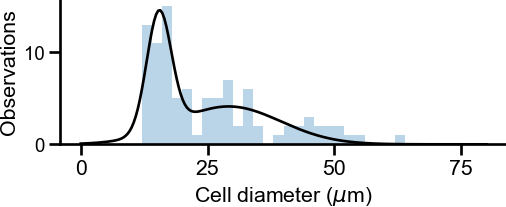

In [6]:
diameters = mydata.diameter.values

plt.figure(figsize=(6,2))
mybins = np.arange(0,80,2)
y, x, _ = plt.hist(diameters, mybins, color='C0', alpha =0.3)

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected = (15, 10, 20, 50, 20, 10)

params,cov = curve_fit(bimodal,x,y,expected)
xfit = np.linspace(0,80,200)

plt.plot(xfit,bimodal(xfit,*params), color='k', lw=2)
plt.ylabel('Observations');
plt.xlabel('Cell diameter ($\mu$m)');
plt.xticks(np.arange(0,100,25));

sigma = np.sqrt(np.diag(cov))
fit_diam = pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:])
fit_diam

## Bimodal distribution of cell resting membrane potential

,params,sigma
mu1,-63.835137,1.708328
sigma1,2.310628,1.643544
A1,10.309785,6.922437
mu2,-28.623628,0.931478
sigma2,12.084117,0.954624
A2,13.853369,0.925939


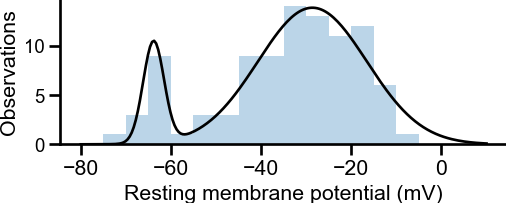

In [7]:
vrest = mydata.Vmb.values

plt.figure(figsize=(6,2))
mybins = np.arange(-80,10,5)
y, x, _ = plt.hist(vrest, mybins, color='C0', alpha =0.3)

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected = (-70, 5, 2, -20, 10, 10)

params,cov = curve_fit(bimodal,x,y,expected)
xfit = np.linspace(-80, 10,200)

plt.plot(xfit,bimodal(xfit,*params), color='k', lw=2);
plt.ylabel('Observations');
plt.xlabel('Resting membrane potential (mV)');

sigma = np.sqrt(np.diag(cov))
fit_vrest = pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:])
fit_vrest

## Plot all together

In [8]:
fit_diam.params.mu1, fit_vrest.params.mu1

(15.433694685495713, -63.835136582515055)

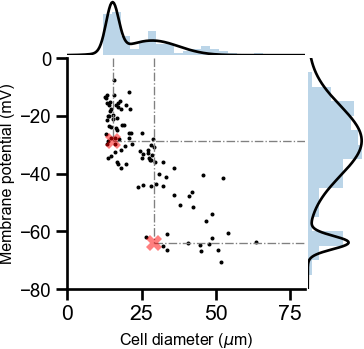

In [9]:
grid = plt.GridSpec(5,5, wspace= 0.05, hspace = 0.05)
fig = plt.figure(figsize=(4,4))

# scatter plot
dots = fig.add_subplot(grid[1:5, 0:4])
mymaks = np.isnan(mydata.Vmb.values)
y = np.ma.array(mydata.Vmb.values, mask = mymaks).compressed()
x = np.ma.array(mydata.diameter.values, mask = mymaks).compressed()
# centroid for 
dots.scatter(x,y,s=4, color='k')
mymarker = dict(markersize = 12, color='red', alpha = 0.5)
dots.plot(fit_diam.params.mu1,fit_vrest.params.mu2, marker='X', **mymarker)
dots.plot(fit_diam.params.mu2,fit_vrest.params.mu1, marker='X', **mymarker)

dots.set_yticks(np.arange(-80,10,20));
dots.set_xticks(np.arange(0,100,25));
dots.set_xlim(0,80)
dots.set_xlabel('Cell diameter ($\mu$m)', fontsize=12);
dots.set_ylim(-80, 0)
dots.set_ylabel('Membrane potential (mV)', fontsize=12)
myparams = dict(color='gray', linestyle='-.', lw=1)
dots.hlines(fit_vrest.params.mu1, xmin = fit_diam.params.mu2, xmax = 80, **myparams)
dots.hlines(fit_vrest.params.mu2, xmin = fit_diam.params.mu1, xmax = 80, **myparams)
dots.vlines(fit_diam.params.mu1, ymin = 0, ymax = fit_vrest.params.mu2, **myparams)
dots.vlines(fit_diam.params.mu2, ymin = 0, ymax = fit_vrest.params.mu1,**myparams)

# up histogram
up = fig.add_subplot(grid[0, 0:4])
mybins = np.arange(0,80,3)
y, x, _ = up.hist(diameters, mybins, color='C0', alpha =0.3)
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)
expected = (15, 10, 20, 70, 20, 10)

params,cov = curve_fit(bimodal,x,y,expected)
xfit = np.linspace(0,80,200)
up.plot(xfit,bimodal(xfit,*params), color='k', lw=2)
up.set_xticks(np.arange(0,100,25));
up.set_xlim(0,80)
up.axis('off')

# left histogram
left = fig.add_subplot(grid[1:5,4:5])
mybins = np.arange(-80,10,5)
y, x, _ = left.hist(vrest, mybins, color='C0', alpha =0.3, orientation='horizontal')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)
expected = (-70, 5, 2, -20, 10, 10)

params,cov = curve_fit(bimodal,x,y,expected)
xfit = np.linspace(-80, 0,200)
left.plot(bimodal(xfit,*params), xfit, color='k', lw=2);
#left.set_xticks(np.arange(0,100,25));
left.set_ylim(-80,0);
left.axis('off');



# Cluster with two centroids 

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [11]:
myscaler = StandardScaler()
z_score = myscaler.fit_transform(mydata)

In [12]:
myscaler.mean_, myscaler.scale_

(array([ 25.67656951, -34.29449021]), array([12.06188709, 15.82171801]))

In [13]:
cfs = KMeans(n_clusters=2).fit(z_score)

In [14]:
# Add groups and colors
mydata['kgroup'] = cfs.labels_


idx_up   = np.where(cfs.labels_ == cfs.labels_[np.argmax(mydata.Vmb.values)])
idx_down = np.where(cfs.labels_ == cfs.labels_[np.argmin(mydata.Vmb.values)])[0]

myblue = '#55a0fb'
myred = '#f94040'

# assign color according to index (up is blue, down in red)
mydata['kcolor'] = myblue
red_idx = mydata.iloc[idx_down].index
mydata.loc[red_idx, 'kcolor'] = myred

In [15]:
from scipy.spatial.distance import cdist

def plot_radii(mykmeans, X, mycolors, ax = None):
    """
    Plots k-centroids from a kmeans model
    
    Arguments
    ---------
    mykmeans (Kmeans object)
        (sklearn.sklearn.cluster.Kmeans model)
    
    X (2D-Numpy array)
        The observations ith the observations)
        
    mycolors (list)
        a 2-element list with rgbcolors (eg., ['#55a0fb', '#f94040'])
    
    ax (an axis object)
    """
    # plot the input data
    ax = ax or plt.gca()
    
    labels = mykmeans.labels_ # read labels

    centers = myscaler.inverse_transform(mykmeans.cluster_centers_) # centroids corrected for normalization!
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    
    
    for center, r , mycolor in zip(centers, radii, mycolors):
        x,y = center
        print(f'center: {x,y}, radius: {r:2.4f}, color: {mycolor}')
        
        mycircle = plt.Circle((x,y), r, color= mycolor, lw=2, alpha=0.15, zorder=1, fill=1)
        ax.add_patch(mycircle)
        ax.plot(x,y, marker = 'P', color = mycolor, markersize =10, alpha= .5)

center: (41.27397910714286, -54.461260714285714), radius: 23.9861, color: #f94040
center: (19.15824908656716, -25.866586119402985), radius: 19.1829, color: #55a0fb


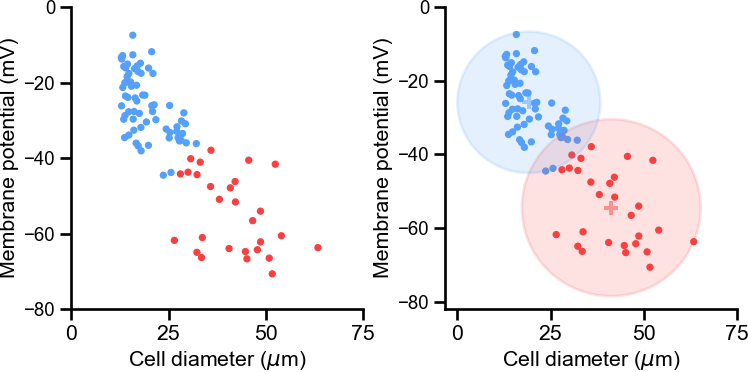

In [16]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
fig.tight_layout()

ax[0].scatter(mydata.diameter, mydata.Vmb, c = mydata.kcolor, s = 20)

plot_radii(mykmeans = cfs, X = mydata.values[:,0:2], mycolors=[myred, myblue], ax=ax[1])
ax[1].scatter(mydata.diameter, mydata.Vmb, c = mydata.kcolor, s = 20)

for myax in ax:
    myax.set_xlabel("Cell diameter ($\mu$m)");
    myax.set_ylabel('Membrane potential (mV)');
    myax.set_yticks(np.arange(-80,10,20));
    myax.set_xticks(np.arange(0,100,25));
#plt.savefig('./figures/K-means.tiff', dpi = 300, bbox_inches='tight')

In [17]:
mydata.head()

,diameter,Vmb,kgroup,kcolor
uid,,,,
Y79_000,20.89430,-27.6512,1,#55a0fb
Y79_001,16.85182,-24.8687,1,#55a0fb
Y79_002,17.95220,-38.0629,1,#55a0fb
Y79_003,15.81813,-12.6591,1,#55a0fb
Y79_004,16.68500,-36.0233,1,#55a0fb


In [18]:
mydata.to_csv('./DataSets/Kmeans_classification.csv', index='uid')

# Calculate inertias

The inertia is the sum of squared distance for each point to it's closest centroid:
<math>
$$ \sum_{i = 1}^{n}{d(x_i, c_k)^2} ,$$
</math>

where $n$ is the number of points,  $c_k$ is the k-centroid, and $d()$ is the euclidian distance.

To detect the minimal number of clusters, we can compute the second derivative of the inertia. Because the inertias are distances, the second derivative can be seen as acceleration, and it gives us an estimation of the largest inertias deviation versus de number of clusters.

In [19]:
inertia = list()
for k in range(2,20):
    clf = KMeans(n_clusters = k, init = 'k-means++').fit(z_score)
    inertia.append( clf.inertia_)

    

Number of optimal k-clusters: 2


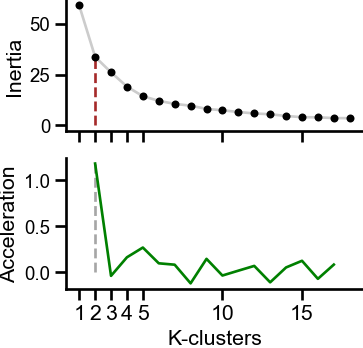

In [20]:
idx = np.arange(1, len(inertia) + 1)

fig, ax = plt.subplots(2, 1, figsize=(4,4), sharex=True)

ax[0].plot(idx, inertia, '-', color='gray', alpha = 0.4)
ax[0].plot(idx, inertia, 'ko', ms=6)
ax[0].set_xticks([1,2,3,4,5, 10, 15])

ax[0].set_ylabel('Inertia');

acceleration = np.diff(np.sqrt(inertia), 2)  # 2nd derivative of the distances

ax[1].plot(idx[:-2] + 1, acceleration, 'g-', ms=8)
ax[1].set_ylabel('Acceleration')
ax[1].set_xlabel('K-clusters')


# calculate clusters
k = acceleration.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
ax[0].vlines(x = k, ymin = 0, ymax = inertia[k-1], color='brown', linestyle='--')
ax[1].vlines(x = k, ymin = 0, ymax = acceleration[k-2], color='gray', linestyle='--', alpha=0.7)

print(f'Number of optimal k-clusters: {k}')
#plt.savefig('./figures/Inertia.tiff', dpi = 300, bbox_inches='tight')